In [39]:
import pandas as pd
import numpy as np
import subprocess
import re
import gzip
import shutil
import tempfile
import os

import random
random.seed(9)
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from peft import LoraConfig, get_peft_model
from transformers import EsmModel, AutoTokenizer # huggingface
from torch.utils.data import Dataset

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, spearmanr

### TM-scoring

In [40]:
def get_tm_score_compressed(pdb_path, reference_path):
    """
    Handles both .pdb and .pdb.gz files by creating a temporary uncompressed file.
    """
    # Create a temporary directory that cleans itself up
    with tempfile.TemporaryDirectory() as tmpdir:
        
        def ensure_unzipped(file_path, name):
            if file_path.endswith('.gz'):
                unzipped_path = os.path.join(tmpdir, name + ".pdb")
                with gzip.open(file_path, 'rb') as f_in:
                    with open(unzipped_path, 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)
                return unzipped_path
            return file_path

        mobile_path = ensure_unzipped(pdb_path, "mobile")
        ref_path = ensure_unzipped(reference_path, "reference")

        try:
            result = subprocess.run(
                ['TMalign', mobile_path, ref_path],
                capture_output=True, text=True, check=True
            )
            
            # Extract scores (index 1 is usually normalized by reference length)
            scores = re.findall(r"TM-score=\s+([0-9.]+)", result.stdout)
            return float(scores[1]) if len(scores) > 1 else None
            
        except subprocess.CalledProcessError:
            return None

# Example usage for a .gz file
# score = get_tm_score_compressed("design_01.pdb.gz", "target.pdb")
# print(f"Score for compressed file: {score}")

In [41]:
interaction_df = pd.read_csv("/work3/s232958/data/meta_analysis/interaction_df_metaanal.csv")[["A_seq", "B_seq", "target_id_mod", "target_binder_ID", "binder", "binder_id"]].rename(columns = {
    "A_seq" : "seq_binder",
    "B_seq" : "seq_target",
    "target_binder_ID" : "binder_id",
    "target_id_mod" : "target_id",
    "binder" : "binder_label",
    "binder_id" : "pdb_name"
})

interaction_df_shuffled = interaction_df.sample(n=100, random_state=0).reset_index(drop=True)
binder_to_pdb = dict(zip(interaction_df_shuffled.pdb_name, interaction_df_shuffled.binder_id))

interaction_df_shuffled

,seq_binder,seq_target,target_id,binder_id,binder_label,pdb_name
0,DIVEEAHKLLSRAMSEAMENDDPDKLRRANELYFKLEEALKNNDPK...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_124,True,Grafting_Motif0374_ems_3hM_501_0001
1,SEELVEKVVEEILNSDLSNDQKILETHDRLMELHDQGKISKEEYYK...,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,EGFR_2,EGFR_2_149,False,chuh_EGFR_Seg1_l58_s941869_mpnn2
2,TINRVFHLHIQGDTEEARKAHEELVEEVRRWAEELAKRLNLTVRVT...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_339,False,rif_fastrot_EHEE_hb1_6273_000000000_0001_0001
3,DDLRKVERIASELAFFAAEQNDTKVAFTALELIHQLIRAIFHNDEE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1234,False,Motif1187_ems_3hM_3215_0001_0001_7049_0001
4,DEEVEELEELLEKAEDPRERAKLLRELAKLIRRDPRLRELATEVVA...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_48,False,il2ra_site1_2b5i_normal_mot_HHH_b2_06557_00000...
...,...,...,...,...,...,...
95,MTTPESLKIHKEVGRAMDYLILMKHYYPEMTDEELKTPEMIEEFAK...,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,EGFR_2,EGFR_2_197,False,darius_szablowski_EGFR_binder_5___ggggs_3_link...
96,TWHLFRDVRVEGDDEEAKKRAKKIADEIVKRSEEWSKRLNLENHTS...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_342,False,rif_fastrot_cor_EHEE_hb1_5158_000000015_0001_0001
97,MWVLTTEGTELDAILGALLAKDLGVRAQVSGPHFRAEFPRREDAER...,VSFPASVQLHTAVEMHHWCIPFSVDGQPAPSLRWLFNGSVLNETSF...,TrkA,TrkA_95,False,Trka_binder_AF2_5
98,PVEELLEEIERTGDPKLVFKVVRLLAEARERGDEELERRVKKVLDI...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1910,False,Motif0041_bcov_4helix_10871_0001_2215_0001


In [42]:
all_meta = list(binder_to_pdb.keys())
# all_PPint_pdbs = random.sample(os.listdir("/work3/s232958/data/PPint_DB/pdb_cache"), 100)

meta_interactions, PPint_interactions = {}, {}

_dir = "/work3/s232958/data/meta_analysis/input_pdbs/"

for file_ref in tqdm(all_meta, desc="References"):
    ref = os.path.join(_dir, f"{file_ref}.pdb.gz")
    key1 = binder_to_pdb[file_ref]
    for file in all_meta:
        path = os.path.join(_dir, f"{file}.pdb.gz")
        score = get_tm_score_compressed(path, ref)
        key2 = binder_to_pdb[file]
        key = f'{key1}&{key2}'
        meta_interactions[key] = score

# Save to CSV for analysis
# df = pd.DataFrame(results)
# df.to_csv("binder_scores.csv", index=False)

References: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [03:01<00:00,  1.82s/it]


In [5]:
# _dir = "/work3/s232958/data/PPint_DB/pdb_cache"

# for file_ref in tqdm(all_PPint_pdbs, desc="References"): 
#     reference = os.path.join(_dir, file_ref)
#     results = []
#     for file in all_PPint_pdbs:
#         if file.endswith(".pdb"):
#             path = os.path.join(_dir, file)
#             score = get_tm_score_compressed(path, reference)
#             PPint_interactions[file_ref] = (file, score)

# # Save to CSV for analysis
# # df = pd.DataFrame(results)
# # df.to_csv("binder_scores.csv", index=False)

### Loading embeddings

In [6]:
def to_numpy(x):
    """Safely convert torch tensor to numpy."""
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    return np.asarray(x)

class ESM2EncoderLoRA(nn.Module):
    def __init__(self, padding_value=-5000.0):
        super().__init__()

        self.padding_value = padding_value

        self.model = EsmModel.from_pretrained(
            "facebook/esm2_t33_650M_UR50D",
            output_hidden_states=True
        )
        self.tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

        # Freeze original weights
        for p in self.model.parameters():
            p.requires_grad = False

        # LoRA on top layers
        lora_cfg = LoraConfig(
            task_type="FEATURE_EXTRACTION",
            inference_mode=False,
            r=4,
            lora_alpha=1,
            lora_dropout=0.1,
            bias="none",
            # target_modules=["query", "key", "value", "dense"],
            target_modules=["query", "key", "value", "dense"],
            layers_to_transform=list(range(25, 33)),
        )

        self.model = get_peft_model(self.model, lora_cfg)

    @torch.no_grad()
    def get_attentions(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs, output_attentions=True)
        return out.attentions   # list[num_layers] → [B, num_heads, L, L]

    def forward(self, sequences):
        inputs = self.tokenizer(
            sequences, return_tensors="pt", padding=True
        ).to(self.model.device)

        out = self.model(**inputs)
        reps = out.hidden_states[-1]                  # [B, Ltok, 1280]
        # reps = reps[:, 1:-1, :]                       # remove CLS/EOS

        # seq_lengths = [len(s) for s in sequences]
        # Lmax = max(seq_lengths)

        # B, D = reps.size(0), reps.size(-1)
        # padded = torch.full((B, Lmax, D), self.padding_value, device=reps.device)

        # for i, (r, real_len) in enumerate(zip(reps, seq_lengths)):
        #     padded[i, :real_len] = r[:real_len]

        return reps

In [8]:
# seq_encoder_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/seq_encoder_cos-sim0.4.pt"
seq_encoder_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_combinedLoss02/2d2b1f23-4d4e-49b0-a768-7625349e0800/seq_encoder_cos-sim0.35.pt"
seq_encoder_state_dict = torch.load(seq_encoder_checkpoint_path, map_location="cuda")
seq_encoder = ESM2EncoderLoRA()
seq_encoder.load_state_dict(seq_encoder_state_dict)
seq_encoder.to("cuda")
seq_encoder.eval()

# seq_down_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/seq_down_cos-sim0.4.pt"
seq_down_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_combinedLoss02/2d2b1f23-4d4e-49b0-a768-7625349e0800/seq_down_cos-sim0.35.pt"
seq_down_state_dict = torch.load(seq_down_checkpoint_path, map_location="cuda")
seq_down = nn.Linear(1280, 512)
seq_down.load_state_dict(seq_down_state_dict)
seq_down.to("cuda")
seq_down.eval()

def compute_esm2_embeddings_Meta(encoder, proj_head, df, tout_dir, bout_dir):
    
    os.makedirs(tout_dir, exist_ok=True)
    os.makedirs(bout_dir, exist_ok=True)
    t_existing = set(f for f in os.listdir(tout_dir) if f.endswith(".npy"))
    b_existing = set(f for f in os.listdir(bout_dir) if f.endswith(".npy"))

    encoder.eval()
    proj_head.eval()

    with torch.no_grad():
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Computing ESM2 embeddings (BOOSTED)"):

            binder_id = row["binder_id"]
            target_id = row["target_id"]

            seq_binder = row["seq_binder"]
            seq_target = row["seq_target"]

            binder_fname = f"{binder_id}.npy"
            target_fname = f"{target_id}.npy"

            # ---- Binder ----
            if binder_fname not in b_existing:
                reps_b = encoder([seq_binder])     # [1, Ltok, Din]
                reps_b = proj_head(reps_b)         # [1, Ltok, Dproj] or [1, Ltok, Din] depending on head
                b_emb = reps_b[0].detach().cpu().numpy()  # [Ltok, D]

                assert b_emb.shape[0] == len(seq_binder) + 2, \
                    f"{binder_id}: {b_emb.shape[0]} vs {len(seq_binder)+2}"

                np.save(os.path.join(bout_dir, binder_fname), b_emb)
                b_existing.add(binder_fname)

            # ---- Target ----
            if target_fname not in t_existing:
                reps_t = encoder([seq_target])
                reps_t = proj_head(reps_t)
                t_emb = reps_t[0].detach().cpu().numpy()

                assert t_emb.shape[0] == len(seq_target) + 2, \
                    f"{target_id}: {t_emb.shape[0]} vs {len(seq_target)+2}"

                np.save(os.path.join(tout_dir, target_fname), t_emb)
                t_existing.add(target_fname)

tout_dir = "/work3/s232958/data/meta_analysis/embeddings_esm2_boosted_targets_combined2cossim35"
bout_dir = "/work3/s232958/data/meta_analysis/embeddings_esm2_boosted_binders_combined2cossim35"

compute_esm2_embeddings_Meta(seq_encoder, seq_down, interaction_df_shuffled, tout_dir, bout_dir)

/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Computing ESM2 embeddings (BOOSTED): 100%|███████████████████████████████████████████| 100/100 [00:00<00:00, 15466.86it/s]


In [9]:
# seq_encoder_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/seq_encoder_cos-sim0.4.pt"
seq_encoder_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_combinedLoss02/2d2b1f23-4d4e-49b0-a768-7625349e0800/seq_encoder_cos-sim0.25.pt"
seq_encoder_state_dict = torch.load(seq_encoder_checkpoint_path, map_location="cuda")
seq_encoder = ESM2EncoderLoRA()
seq_encoder.load_state_dict(seq_encoder_state_dict)
seq_encoder.to("cuda")
seq_encoder.eval()

# seq_down_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/seq_down_cos-sim0.4.pt"
seq_down_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_combinedLoss02/2d2b1f23-4d4e-49b0-a768-7625349e0800/seq_down_cos-sim0.25.pt"
seq_down_state_dict = torch.load(seq_down_checkpoint_path, map_location="cuda")
seq_down = nn.Linear(1280, 512)
seq_down.load_state_dict(seq_down_state_dict)
seq_down.to("cuda")
seq_down.eval()

def compute_esm2_embeddings_Meta(encoder, proj_head, df, tout_dir, bout_dir):
    
    os.makedirs(tout_dir, exist_ok=True)
    os.makedirs(bout_dir, exist_ok=True)
    t_existing = set(f for f in os.listdir(tout_dir) if f.endswith(".npy"))
    b_existing = set(f for f in os.listdir(bout_dir) if f.endswith(".npy"))

    encoder.eval()
    proj_head.eval()

    with torch.no_grad():
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Computing ESM2 embeddings (BOOSTED)"):

            binder_id = row["binder_id"]
            target_id = row["target_id"]

            seq_binder = row["seq_binder"]
            seq_target = row["seq_target"]

            binder_fname = f"{binder_id}.npy"
            target_fname = f"{target_id}.npy"

            # ---- Binder ----
            if binder_fname not in b_existing:
                reps_b = encoder([seq_binder])     # [1, Ltok, Din]
                reps_b = proj_head(reps_b)         # [1, Ltok, Dproj] or [1, Ltok, Din] depending on head
                b_emb = reps_b[0].detach().cpu().numpy()  # [Ltok, D]

                assert b_emb.shape[0] == len(seq_binder) + 2, \
                    f"{binder_id}: {b_emb.shape[0]} vs {len(seq_binder)+2}"

                np.save(os.path.join(bout_dir, binder_fname), b_emb)
                b_existing.add(binder_fname)

            # ---- Target ----
            if target_fname not in t_existing:
                reps_t = encoder([seq_target])
                reps_t = proj_head(reps_t)
                t_emb = reps_t[0].detach().cpu().numpy()

                assert t_emb.shape[0] == len(seq_target) + 2, \
                    f"{target_id}: {t_emb.shape[0]} vs {len(seq_target)+2}"

                np.save(os.path.join(tout_dir, target_fname), t_emb)
                t_existing.add(target_fname)

tout_dir = "/work3/s232958/data/meta_analysis/embeddings_esm2_boosted_targets_combined2cossim25"
bout_dir = "/work3/s232958/data/meta_analysis/embeddings_esm2_boosted_binders_combined2cossim25"

compute_esm2_embeddings_Meta(seq_encoder, seq_down, interaction_df_shuffled, tout_dir, bout_dir)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Computing ESM2 embeddings (BOOSTED): 100%|███████████████████████████████████████████| 100/100 [00:00<00:00, 15300.98it/s]


In [51]:
# seq_encoder_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/seq_encoder_cos-sim0.4.pt"
seq_encoder_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_combinedLoss02/2d2b1f23-4d4e-49b0-a768-7625349e0800/seq_encoder_cos-sim0.2.pt"
seq_encoder_state_dict = torch.load(seq_encoder_checkpoint_path, map_location="cuda")
seq_encoder = ESM2EncoderLoRA()
seq_encoder.load_state_dict(seq_encoder_state_dict)
seq_encoder.to("cuda")
seq_encoder.eval()

# seq_down_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/seq_down_cos-sim0.4.pt"
seq_down_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_combinedLoss02/2d2b1f23-4d4e-49b0-a768-7625349e0800/seq_down_cos-sim0.2.pt"
seq_down_state_dict = torch.load(seq_down_checkpoint_path, map_location="cuda")
seq_down = nn.Linear(1280, 512)
seq_down.load_state_dict(seq_down_state_dict)
seq_down.to("cuda")
seq_down.eval()

def compute_esm2_embeddings_Meta(encoder, proj_head, df, tout_dir, bout_dir):
    
    os.makedirs(tout_dir, exist_ok=True)
    os.makedirs(bout_dir, exist_ok=True)
    t_existing = set(f for f in os.listdir(tout_dir) if f.endswith(".npy"))
    b_existing = set(f for f in os.listdir(bout_dir) if f.endswith(".npy"))

    encoder.eval()
    proj_head.eval()

    with torch.no_grad():
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Computing ESM2 embeddings (BOOSTED)"):

            binder_id = row["binder_id"]
            target_id = row["target_id"]

            seq_binder = row["seq_binder"]
            seq_target = row["seq_target"]

            binder_fname = f"{binder_id}.npy"
            target_fname = f"{target_id}.npy"

            # ---- Binder ----
            if binder_fname not in b_existing:
                reps_b = encoder([seq_binder])     # [1, Ltok, Din]
                reps_b = proj_head(reps_b)         # [1, Ltok, Dproj] or [1, Ltok, Din] depending on head
                b_emb = reps_b[0].detach().cpu().numpy()  # [Ltok, D]

                assert b_emb.shape[0] == len(seq_binder) + 2, \
                    f"{binder_id}: {b_emb.shape[0]} vs {len(seq_binder)+2}"

                np.save(os.path.join(bout_dir, binder_fname), b_emb)
                b_existing.add(binder_fname)

            # ---- Target ----
            if target_fname not in t_existing:
                reps_t = encoder([seq_target])
                reps_t = proj_head(reps_t)
                t_emb = reps_t[0].detach().cpu().numpy()

                assert t_emb.shape[0] == len(seq_target) + 2, \
                    f"{target_id}: {t_emb.shape[0]} vs {len(seq_target)+2}"

                np.save(os.path.join(tout_dir, target_fname), t_emb)
                t_existing.add(target_fname)

tout_dir = "/work3/s232958/data/meta_analysis/embeddings_esm2_boosted_targets_combined2cossim20"
bout_dir = "/work3/s232958/data/meta_analysis/embeddings_esm2_boosted_binders_combined2cossim20"

compute_esm2_embeddings_Meta(seq_encoder, seq_down, interaction_df_shuffled, tout_dir, bout_dir)

/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Computing ESM2 embeddings (BOOSTED): 100%|██████████████████████████████████████████████| 100/100 [00:14<00:00,  7.12it/s]


In [10]:
# seq_encoder_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/seq_encoder_cos-sim0.4.pt"
seq_encoder_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_combinedLoss02/2d2b1f23-4d4e-49b0-a768-7625349e0800/seq_encoder_cos-sim0.15.pt"
seq_encoder_state_dict = torch.load(seq_encoder_checkpoint_path, map_location="cuda")
seq_encoder = ESM2EncoderLoRA()
seq_encoder.load_state_dict(seq_encoder_state_dict)
seq_encoder.to("cuda")
seq_encoder.eval()

# seq_down_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_NewLoss/5e338957-e280-40f1-a29f-b0c6b1551994/seq_down_cos-sim0.4.pt"
seq_down_checkpoint_path = "/work3/s232958/data/trained/boostingESM2wESMIF/train_on_PPint_combinedLoss02/2d2b1f23-4d4e-49b0-a768-7625349e0800/seq_down_cos-sim0.15.pt"
seq_down_state_dict = torch.load(seq_down_checkpoint_path, map_location="cuda")
seq_down = nn.Linear(1280, 512)
seq_down.load_state_dict(seq_down_state_dict)
seq_down.to("cuda")
seq_down.eval()

def compute_esm2_embeddings_Meta(encoder, proj_head, df, tout_dir, bout_dir):
    
    os.makedirs(tout_dir, exist_ok=True)
    os.makedirs(bout_dir, exist_ok=True)
    t_existing = set(f for f in os.listdir(tout_dir) if f.endswith(".npy"))
    b_existing = set(f for f in os.listdir(bout_dir) if f.endswith(".npy"))

    encoder.eval()
    proj_head.eval()

    with torch.no_grad():
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Computing ESM2 embeddings (BOOSTED)"):

            binder_id = row["binder_id"]
            target_id = row["target_id"]

            seq_binder = row["seq_binder"]
            seq_target = row["seq_target"]

            binder_fname = f"{binder_id}.npy"
            target_fname = f"{target_id}.npy"

            # ---- Binder ----
            if binder_fname not in b_existing:
                reps_b = encoder([seq_binder])     # [1, Ltok, Din]
                reps_b = proj_head(reps_b)         # [1, Ltok, Dproj] or [1, Ltok, Din] depending on head
                b_emb = reps_b[0].detach().cpu().numpy()  # [Ltok, D]

                assert b_emb.shape[0] == len(seq_binder) + 2, \
                    f"{binder_id}: {b_emb.shape[0]} vs {len(seq_binder)+2}"

                np.save(os.path.join(bout_dir, binder_fname), b_emb)
                b_existing.add(binder_fname)

            # ---- Target ----
            if target_fname not in t_existing:
                reps_t = encoder([seq_target])
                reps_t = proj_head(reps_t)
                t_emb = reps_t[0].detach().cpu().numpy()

                assert t_emb.shape[0] == len(seq_target) + 2, \
                    f"{target_id}: {t_emb.shape[0]} vs {len(seq_target)+2}"

                np.save(os.path.join(tout_dir, target_fname), t_emb)
                t_existing.add(target_fname)

tout_dir = "/work3/s232958/data/meta_analysis/embeddings_esm2_boosted_targets_combined2cossim15"
bout_dir = "/work3/s232958/data/meta_analysis/embeddings_esm2_boosted_binders_combined2cossim15"

compute_esm2_embeddings_Meta(seq_encoder, seq_down, interaction_df_shuffled, tout_dir, bout_dir)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Computing ESM2 embeddings (BOOSTED): 100%|███████████████████████████████████████████| 100/100 [00:00<00:00, 15181.35it/s]


In [52]:
class CLIP_Meta(Dataset):
    def __init__(
        self,
        dframe,
        path,
        embedding_dim=512,
        embedding_pad_value=-5000.0
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim = int(embedding_dim)
        
        # paths
        self.encoding_bpath = path

        # index & storage
        self.dframe.set_index("binder_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.samples = []
        self.binder_ids = []

        for accession in tqdm(self.accessions, desc="#Pooling ESM2 embeddings"):
            parts = accession.split("_")
            bnd_id = accession
            b_emb_raw = np.load(os.path.join(self.encoding_bpath, f"{bnd_id}.npy"))
            b_pooled = self._pool_embedding(b_emb_raw)

            self.samples.append(b_pooled)
            self.binder_ids.append(bnd_id)

    def _pool_embedding(self, emb):
        core_emb = emb[1:-1, :]
        return torch.from_numpy(core_emb.mean(axis=0)).float()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.binder_ids[idx], self.samples[idx]

# Cos-Sim 0.15
temb_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_boosted_targets_combined2cossim15/"
bemb_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_boosted_binders_combined2cossim15/"

ESM2_boost_CS15_embeddings_Meta = CLIP_Meta(
    interaction_df_shuffled,
    path=bemb_path,
    embedding_dim=512
)

# Cos-Sim 0.20
temb_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_boosted_targets_combined2cossim20/"
bemb_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_boosted_binders_combined2cossim20/"

ESM2_boost_CS20_embeddings_Meta = CLIP_Meta(
    interaction_df_shuffled,
    path=bemb_path,
    embedding_dim=512
)

# Cos-Sim 0.25
temb_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_boosted_targets_combined2cossim25/"
bemb_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_boosted_binders_combined2cossim25/"

ESM2_boost_CS25_embeddings_Meta = CLIP_Meta(
    interaction_df_shuffled,
    path=bemb_path,
    embedding_dim=512
)

# Cos-Sim 0.35
temb_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_boosted_targets_combined2cossim35/"
bemb_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_boosted_binders_combined2cossim35/"

ESM2_boost_CS35_embeddings_Meta = CLIP_Meta(
    interaction_df_shuffled,
    path=bemb_path,
    embedding_dim=512
)

# Original ESM-2
bemb_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_binders"
temb_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_targets"

ESM2org_embeddings_Meta= CLIP_Meta(
    # interaction_df_shuffled[:len(Df_test)],
    interaction_df_shuffled,
    path = bemb_path,
    embedding_dim=1280
)

# Original ESM-IF
bemb_path = "/work3/s232958/data/meta_analysis/esmif_embeddings_binders"
temb_path = "/work3/s232958/data/meta_analysis/esmif_embeddings_targets"

ESMIForg_embeddings_Meta= CLIP_Meta(
    # interaction_df_shuffled[:len(Df_test)],
    interaction_df_shuffled,
    path = bemb_path,
    embedding_dim=512
)

#Pooling ESM2 embeddings: 100%|████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 842.08it/s]


In [13]:
def compute_embeddings_cos_similariy(embedding1, embedding2):
    id1, emb1 = embedding1
    id2, emb2 = embedding2
    cossim = F.cosine_similarity(emb1, emb2, dim=-1)
    return id1, id2, round(float(cossim.item()), 5)

compute_embeddings_cos_similariy(ESM2_boost_CS15_embeddings_Meta[0], ESM2_boost_CS15_embeddings_Meta[0])

('FGFR2_124', 'FGFR2_124', 1.0)

In [14]:
list(meta_interactions.items())[255]

('FGFR2_339&FGFR2_1731', 0.84775)

In [54]:
# Cos-Sim 0.15
meta_cosim_ESM2_boost15 = {}
for i in range(len(ESM2_boost_CS15_embeddings_Meta)):
    for j in range(len(ESM2_boost_CS15_embeddings_Meta)):
        id1, id2, cossim = compute_embeddings_cos_similariy(ESM2_boost_CS15_embeddings_Meta[i], ESM2_boost_CS15_embeddings_Meta[j])
        if id1 != id2:
            key = f'{id1}&{id2}'
            key_reverse = f'{id2}&{id1}'
            if key_reverse not in meta_cosim_ESM2_boost15.keys():
                meta_cosim_ESM2_boost15[key] = cossim
        else:
            pass

print(f"ESM2_boost15: {list(meta_cosim_ESM2_boost15.items())[255]}")

# Cos-Sim 0.20
meta_cosim_ESM2_boost20 = {}
for i in range(len(ESM2_boost_CS20_embeddings_Meta)):
    for j in range(len(ESM2_boost_CS20_embeddings_Meta)):
        id1, id2, cossim = compute_embeddings_cos_similariy(ESM2_boost_CS20_embeddings_Meta[i], ESM2_boost_CS20_embeddings_Meta[j])
        if id1 != id2:
            key = f'{id1}&{id2}'
            key_reverse = f'{id2}&{id1}'
            if key_reverse not in meta_cosim_ESM2_boost20.keys():
                meta_cosim_ESM2_boost20[key] = cossim
        else:
            pass

print(f"ESM2_boost20: {list(meta_cosim_ESM2_boost20.items())[255]}")

# Cos-Sim 0.25
meta_cosim_ESM2_boost25 = {}
for i in range(len(ESM2_boost_CS25_embeddings_Meta)):
    for j in range(len(ESM2_boost_CS25_embeddings_Meta)):
        id1, id2, cossim = compute_embeddings_cos_similariy(ESM2_boost_CS25_embeddings_Meta[i], ESM2_boost_CS25_embeddings_Meta[j])
        if id1 != id2:
            key = f'{id1}&{id2}'
            key_reverse = f'{id2}&{id1}'
            if key_reverse not in meta_cosim_ESM2_boost25.keys():
                meta_cosim_ESM2_boost25[key] = cossim
        else:
            pass

print(f"ESM2_boost25: {list(meta_cosim_ESM2_boost25.items())[255]}")

# Cos-Sim 0.35
meta_cosim_ESM2_boost35 = {}
for i in range(len(ESM2_boost_CS35_embeddings_Meta)):
    for j in range(len(ESM2_boost_CS35_embeddings_Meta)):
        id1, id2, cossim = compute_embeddings_cos_similariy(ESM2_boost_CS35_embeddings_Meta[i], ESM2_boost_CS35_embeddings_Meta[j])
        if id1 != id2:
            key = f'{id1}&{id2}'
            key_reverse = f'{id2}&{id1}'
            if key_reverse not in meta_cosim_ESM2_boost35.keys():
                meta_cosim_ESM2_boost35[key] = cossim
        else:
            pass

print(f"ESM2_boost35: {list(meta_cosim_ESM2_boost35.items())[255]}")

ESM2_boost15: ('FGFR2_339&InsulinR_34', 0.60204)
ESM2_boost20: ('FGFR2_339&InsulinR_34', 0.53286)
ESM2_boost25: ('FGFR2_339&InsulinR_34', 0.58722)
ESM2_boost35: ('FGFR2_339&InsulinR_34', 0.65917)


In [55]:
meta_cosim_ESM2_boost35["InsulinR_34&FGFR2_339"]

KeyError: 'InsulinR_34&FGFR2_339'

In [27]:
meta_cosim_orgESMIF = {}
for i in range(len(ESMIForg_embeddings_Meta)):
    for j in range(len(ESMIForg_embeddings_Meta)):
        id1, id2, cossim = compute_embeddings_cos_similariy(ESMIForg_embeddings_Meta[i], ESMIForg_embeddings_Meta[j])
        if id1 != id2:
            key = f'{id1}&{id2}'
            key_reverse = f'{id2}&{id1}'
            if key_reverse not in meta_cosim_orgESMIF.keys():
                meta_cosim_orgESMIF[key] = cossim
        else:
            pass

print(f"orgESMIF: {list(meta_cosim_orgESMIF.items())[255]}")

orgESMIF: ('FGFR2_339&InsulinR_34', 0.60266)


In [28]:
meta_cosim_orgESM2 = {}
for i in range(len(ESM2org_embeddings_Meta)):
    for j in range(len(ESM2org_embeddings_Meta)):
        id1, id2, cossim = compute_embeddings_cos_similariy(ESM2org_embeddings_Meta[i], ESM2org_embeddings_Meta[j])
        if id1 != id2:
            key = f'{id1}&{id2}'
            key_reverse = f'{id2}&{id1}'
            if key_reverse not in meta_cosim_orgESM2.keys():
                meta_cosim_orgESM2[key] = cossim
        else:
            pass

print(f"orgESM2: {list(meta_cosim_orgESM2.items())[255]}")

orgESM2: ('FGFR2_339&InsulinR_34', 0.96376)


In [37]:
print(len(meta_cosim_ESM2_boost15))
print(len(meta_cosim_ESM2_boost25))
print(len(meta_cosim_ESM2_boost35))
print(len(meta_cosim_orgESMIF))
print(len(meta_cosim_orgESM2))
print(len(meta_interactions)) # needs to be filtered

4950
4950
4950
4950
4950
10000


In [43]:
meta_interactions_filtered = {}
for key, value in meta_interactions.items():
    if key in meta_cosim_orgESM2.keys():
        meta_interactions_filtered[key] = value
print(len(meta_interactions_filtered))

4950


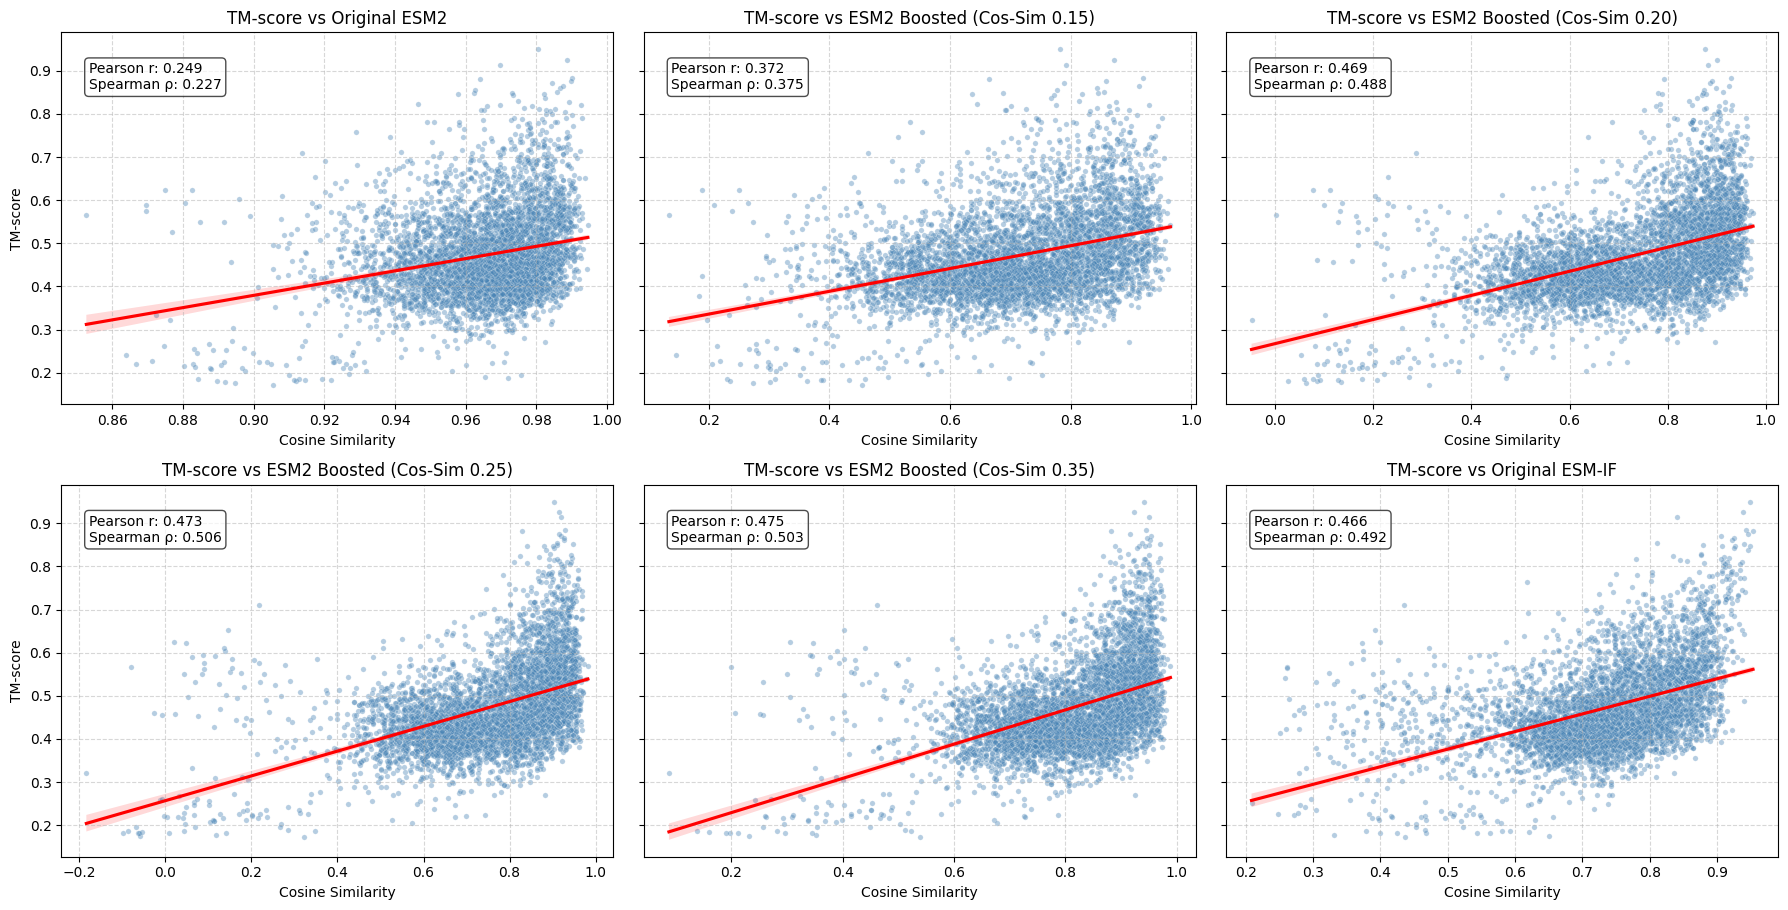

In [57]:
# 1. Define your data mapping
# Format: { "Title for Plot": data_dictionary }
models = {
    "TM-score vs Original ESM2": meta_cosim_orgESM2,
    "TM-score vs ESM2 Boosted (Cos-Sim 0.15)": meta_cosim_ESM2_boost15,
    "TM-score vs ESM2 Boosted (Cos-Sim 0.20)": meta_cosim_ESM2_boost20,
    "TM-score vs ESM2 Boosted (Cos-Sim 0.25)": meta_cosim_ESM2_boost25,
    "TM-score vs ESM2 Boosted (Cos-Sim 0.35)": meta_cosim_ESM2_boost35,
    "TM-score vs Original ESM-IF": meta_cosim_orgESMIF,
    # "TM-score vs TM-score": meta_interactions_filtered
}

# 2. Extract the ground truth (TM-scores)
# Assuming meta_interactions or a specific dict contains your TM-scores
# Let's assume 'tm_scores_dict' is your reference list for the Y-axis
tm_scores = list(meta_interactions_filtered.values()) 

# 3. Create a 2x3 Grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
axes = axes.flatten()

for i, (name, data_dict) in enumerate(models.items()):
    ax = axes[i]
    
    # Ensure lists are aligned (important for correlation)
    x_vals = list(data_dict.values())
    y_vals = tm_scores # This stays constant as the ground truth
    
    # Calculate Stats
    p_corr, _ = pearsonr(x_vals, y_vals)
    s_corr, _ = spearmanr(x_vals, y_vals)
    
    # Plotting
    sns.scatterplot(x=x_vals, y=y_vals, alpha=0.4, s=15, ax=ax, color='steelblue')
    sns.regplot(x=x_vals, y=y_vals, scatter=False, color='red', ax=ax)
    
    # Annotate with stats
    stats_text = f"Pearson r: {p_corr:.3f}\nSpearman ρ: {s_corr:.3f}"
    ax.text(0.05, 0.92, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    # ax.set_xlim(0, 1)
    # ax.set_ylim(0, 1)
    
    ax.set_title(name, fontsize=12)
    ax.set_xlabel("Cosine Similarity")
    if i % 3 == 0:
        ax.set_ylabel("TM-score")
    ax.grid(True, linestyle='--', alpha=0.5)

# plt.suptitle("Comparative Correlation Analysis: TM-score vs. Various Embedding Models", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

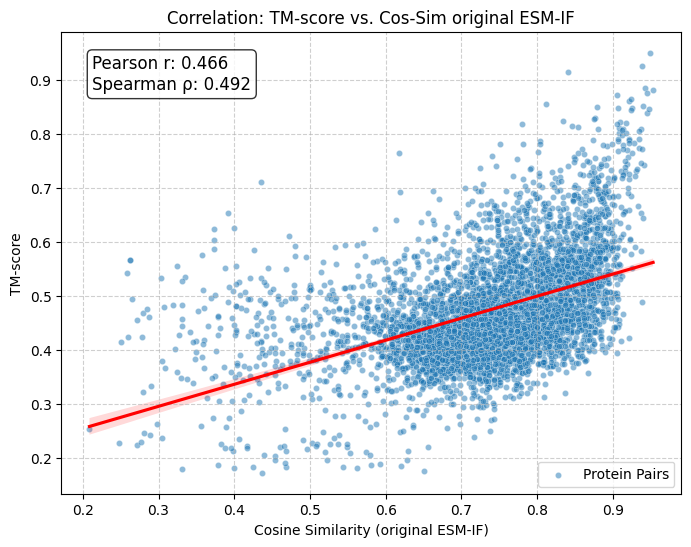

In [47]:
# 1. Ensure lists are aligned and numeric
y_vals = list(meta_interactions_filtered.values())
x_vals = list(meta_cosim_orgESMIF.values())

# 2. Calculate Correlations
p_corr, p_pval = pearsonr(x_vals, y_vals)
s_corr, s_pval = spearmanr(x_vals, y_vals)

# 3. Create the plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x_vals, y=y_vals, alpha=0.5, s=20, label="Protein Pairs")

# Add a trend line (regression line)
sns.regplot(x=x_vals, y=y_vals, scatter=False, color='red', line_kws={"label":"Linear Fit"})

# 4. Add the correlation text box
stats_text = (f"Pearson r: {p_corr:.3f}\n"
              f"Spearman ρ: {s_corr:.3f}")

# Positioning the text in the upper left (standard for these plots)
plt.gca().text(0.05, 0.95, stats_text, transform=plt.gca().transAxes,
               fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Labeling
plt.xlabel("Cosine Similarity (original ESM-IF)")
plt.ylabel("TM-score")
plt.title("Correlation: TM-score vs. Cos-Sim original ESM-IF")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')

plt.show()

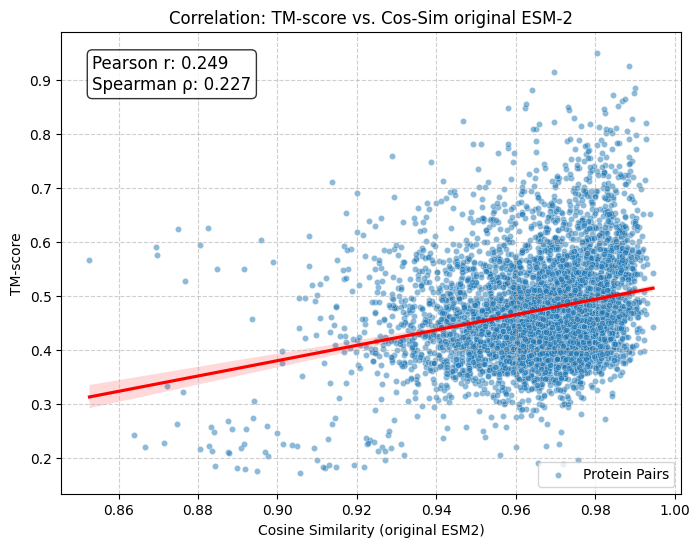

In [48]:
# 1. Ensure lists are aligned and numeric
x_vals = list(meta_cosim_orgESM2.values())
y_vals = list(meta_interactions_filtered.values())

# 2. Calculate Correlations
p_corr, p_pval = pearsonr(x_vals, y_vals)
s_corr, s_pval = spearmanr(x_vals, y_vals)

# 3. Create the plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x_vals, y=y_vals, alpha=0.5, s=20, label="Protein Pairs")

# Add a trend line (regression line)
sns.regplot(x=x_vals, y=y_vals, scatter=False, color='red', line_kws={"label":"Linear Fit"})

# 4. Add the correlation text box
stats_text = (f"Pearson r: {p_corr:.3f}\n"
              f"Spearman ρ: {s_corr:.3f}")

# Positioning the text in the upper left (standard for these plots)
plt.gca().text(0.05, 0.95, stats_text, transform=plt.gca().transAxes,
               fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Labeling
plt.xlabel("Cosine Similarity (original ESM2)")
plt.ylabel("TM-score")
plt.title("Correlation: TM-score vs. Cos-Sim original ESM-2")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')

plt.show()

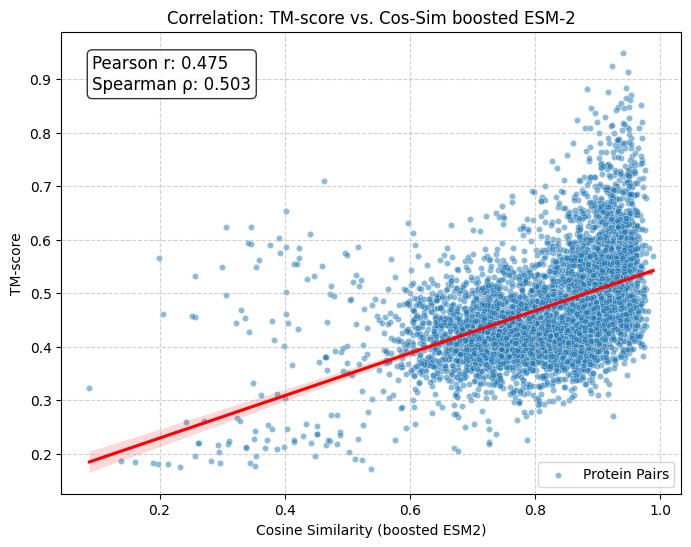

In [50]:
# 1. Ensure lists are aligned and numeric
y_vals = list(meta_interactions_filtered.values())
x_vals = list(meta_cosim_ESM2_boost35.values())

# 2. Calculate Correlations
p_corr, p_pval = pearsonr(x_vals, y_vals)
s_corr, s_pval = spearmanr(x_vals, y_vals)

# 3. Create the plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x_vals, y=y_vals, alpha=0.5, s=20, label="Protein Pairs")

# Add a trend line (regression line)
sns.regplot(x=x_vals, y=y_vals, scatter=False, color='red', line_kws={"label":"Linear Fit"})

# 4. Add the correlation text box
stats_text = (f"Pearson r: {p_corr:.3f}\n"
              f"Spearman ρ: {s_corr:.3f}")

# Positioning the text in the upper left (standard for these plots)
plt.gca().text(0.05, 0.95, stats_text, transform=plt.gca().transAxes,
               fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Labeling
plt.xlabel("Cosine Similarity (boosted ESM2)")
plt.ylabel("TM-score")
plt.title("Correlation: TM-score vs. Cos-Sim boosted ESM-2")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')

plt.show()